# Count Estimation Tutorial

In this notebook, we provide the example code for estimating building count in the **New York State** using isotonic regression.

In [1]:
import random
import os
import sys
import torch

import numpy as np
from matplotlib import cm, pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from tqdm import tqdm

import rasterio as rs
import rasterio

from sklearn.isotonic import IsotonicRegression
from scipy import spatial

import geopy
import geopy.distance
import geoplot as gplt

sys.path.append('..')
from utils.utils import ray_tracing_numpy_numba, pixel_to_coord, load_geotiff, coord_to_pixel_loaded, create_data, compute_pixel_size, kd_tree_object_count
from utils.constants import GT_MS_COUNT, GT_OPEN_BUILDINGS_COUNT, US_STATES, AFRICAN_COUNTRIES

## Define util functions

In [2]:
def get_index(name_list, district):
    for i in range(len(name_list)):
        name = name_list[i].lower()
        name = name.replace(" ", "_")
        if name == district:
            return i
    print("district {} not found in the us states".format(district))
    exit()

## Define necessary values

In [3]:
country = 'us'
district = 'new_york'
sampling_method = 'NL'

percentage = 0.002
satellite_size = 640 * 0.0003

extra_train = False

num_run = 5
group_run = 1

## Load the training and testing data

In [4]:
all_probs = {}
all_lats, all_lons, all_s_pix, all_probs['nl'], all_probs['pop'] = torch.load(f"../sample_data/{sampling_method}/sample_{country}_{district}_All_area.pth")

# Load training data (50% positive + 50% negative)
lats1, lons1, probs_nl1, probs_pop1, counts1 = torch.load(
    f"../sample_data/{sampling_method}/sample_2000_{country}_{district}_True.pth")

lats2, lons2, probs_nl2, probs_pop2, counts2 = torch.load(
    f"../sample_data/{sampling_method}/sample_2000_{country}_{district}_False.pth")

if sampling_method == "NL":
    all_base = all_probs['nl'].reshape(-1, 1)
    train_base = np.append(probs_nl1, probs_nl2)
elif sampling_method == "population":
    all_base = all_probs['pop'].reshape(-1, 1)
    train_base = np.append(probs_pop1, probs_pop2)

In [5]:
vmax = (all_base / all_base.sum()).max()
vmin = (all_base / all_base.sum()).min()

print(len(train_base))
permute = np.random.permutation(len(train_base))
train_base = train_base[permute]
counts = np.append(counts1, counts2)[permute]

4000


In [6]:
print('Creating training and testing data...')
base_mean = np.mean(all_base, axis=0, keepdims=True) # (1, 1) todo: check dim
base_std = np.std(all_base, axis=0, keepdims=True) # (1, 1)

train_base = train_base.reshape(train_base.shape[0], -1)
train_base = train_base - base_mean
train_base = train_base / base_std
print('Data created')

area = all_s_pix.sum()
total_sample_size = area * percentage / (satellite_size ** 2)
total_sample_size = int((total_sample_size // 20 + 1) * 20)
trial_size = total_sample_size
training_size = min(5000, int(trial_size * 0.2)) # used to be int(args.trial_size * 0.2)
if not extra_train:
    trial_size = trial_size - training_size
print("training {}, total {}".format(training_size, trial_size, training_size+trial_size))

Creating training and testing data...
Data created
training 1384, total 5536


## Learn the proposal distribution and sample from it

In [7]:
# Fit the data using isotonic regression
iso_reg = IsotonicRegression(out_of_bounds='clip').fit(train_base[:training_size], counts[:training_size])

In [8]:
# Perform sampling from the model-learned distribution
print("Sampling from the model distribution...")
all_base_normalized = all_base - base_mean
all_base_normalized = all_base_normalized / base_std
pred = iso_reg.predict(all_base_normalized)
print(pred.max(), pred.min())
pred = np.clip(pred, a_min=0, a_max=1e20)
prob_model = pred * all_s_pix / (pred * all_s_pix).sum()

total_sample_size = trial_size * num_run
ix = np.random.choice(range(len(all_lons)), size=total_sample_size, replace=True, p=prob_model)
sample_lons, sample_lats, s_pix, pix_value, prob_model_subset = all_lons[ix], all_lats[ix], all_s_pix[ix], pred[ix], prob_model[ix]
print("Sampling done...")

Sampling from the model distribution...
42.58371040723982 0.0
Sampling done...


## Collect object count for the samples

In [9]:
# Get necessary terms for estimating total count
area = all_s_pix.sum()  # AREA[district]
uniform_prob = s_pix / area

In [11]:
# Load MS ground truth building dataset
gt_count = 4972497. # GT count for New York State
[center_x, center_y] = torch.load(f"../sample_data/ms_building_footprint/{country}/{''.join(district.split('_'))}_center.pth")
center_x, center_y = np.array(center_x), np.array(center_y)

In [35]:
# collect the correpsonding object counts
object_count_array = []
print("Collecting object count...")

points = np.stack([center_x, center_y], axis=1)
samples = np.stack([sample_lons, sample_lats], axis=1)

print("Building tree...")
tree = spatial.KDTree(points)
num_neighbor = 5000
object_count_array = kd_tree_object_count(satellite_size, samples, sample_lats, sample_lons, tree, center_x, center_y, num_neighbor=num_neighbor)

torch.save([sample_lats, sample_lons, s_pix, pix_value, prob_model_subset, object_count_array], 
           f'../sample_data/{sampling_method}/sample_{country}_{district}_{percentage}_{len(sample_lats)}_model_based.pth')

Building tree...
Querying tree...
Getting bounding boxes...
Creating masks
Masks created
Object count collected


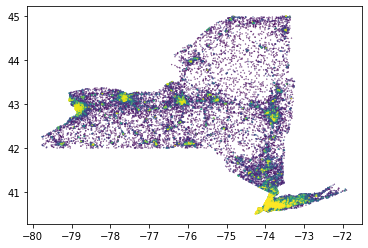

In [38]:
# Visualize all sampled points, colored by the probabilities given by the learned distribution
plt.scatter(sample_lons, sample_lats, c=prob_model_subset, s=0.1)

In [41]:
print("Computing accuracy...")
accuracy_array = []
for run in tqdm(range(num_run * group_run)):
    accuracy = []
    probs = prob_model_subset[run * trial_size : (run+1) * trial_size]
    object_count = object_count_array[run * trial_size : (run+1) * trial_size]
    pix_value_perm = pix_value[run * trial_size : (run+1) * trial_size]

    for sample_num in range(1, trial_size + 1, 20):
        s_image = satellite_size ** 2
        m = sample_num
        prob = pix_value_perm[:sample_num] / (all_s_pix * pred).sum()
        f_x = object_count[:sample_num]
        total_count = (1. / s_image) * (1.0 / prob) * f_x
        total_count = total_count.sum() / m
        accuracy.append(total_count / gt_count)
    accuracy_array.append(accuracy)
accuracy_array = np.concatenate(accuracy_array, axis=0)
accuracy_array = accuracy_array.reshape(num_run, group_run, -1).mean(axis=1)

 20%|██        | 1/5 [00:00<00:00,  7.03it/s]

Computing accuracy...


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


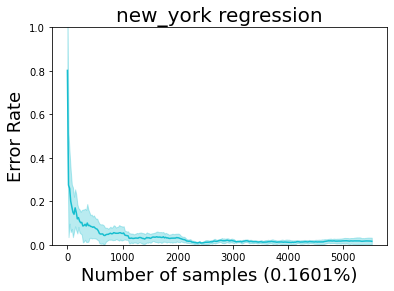

In [45]:
error_array = np.abs(1. - accuracy_array)
mean = error_array.mean(axis=0)
std = error_array.std(axis=0)

x_labels = range(1, trial_size + 1, 20)
plt.plot(x_labels, mean, color="Tab:cyan")
plt.fill_between(x_labels, mean + std, mean - std, color="Tab:cyan", alpha=0.3)

plt.ylabel("Error Rate", fontsize=18)
plt.xlabel("Number of samples ({:.4f}%)".format(trial_size * 100 * s_image / area), fontsize=18)
plt.ylim(0., 1.)


fig_name = "isotonic_error_{}_{}_{}_{}_{}_{}.png".format(country,
                                                         district,
                                                         training_size,
                                                         num_run,
                                                         group_run,
                                                         trial_size,
                                                         total_sample_size)
plt.title("{} {}".format(district, "regression"), fontsize=20)
os.makedirs(f'../figures/{sampling_method}/', exist_ok=True)
plt.show()
plt.savefig(f"../figures/{sampling_method}/{fig_name}")
plt.close()